# INTRODUCTION

This notebook serves as a comprehensive tool for analyzing and predicting Bridge Scores, a metric designed to assess bipartisan collaboration and legislative effectiveness among U.S. House members. It includes the following functionalities:

* Data Exploration: Visualize and understand the distribution and correlations within the dataset.
* Model Training and Evaluation: Train machine learning models to predict Bridge Scores and evaluate their performance.
* Custom Weights: Allow users to define or modify weights for different metrics, enabling flexible scoring.
* New Data Scoring: Score and grade new datasets, including the flexibility to incorporate custom metrics and weights.


By combining exploratory analysis, machine learning, and customizability, this notebook aims to provide robust model to calculate Bridge score and assign a Bridge grade.

# Import Libraries

In [1]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import matplotlib.pyplot as plt  # For plotting charts
import seaborn as sns  # For creating visually appealing statistical plots
import pandas as pd  # For working with data in a tabular format
import json  # For reading and working with JSON data
from sklearn.ensemble import RandomForestRegressor  # Machine learning model for regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve  # For model evaluation and training
from sklearn.metrics import mean_squared_error, r2_score  # For evaluating model performance
from sklearn.impute import SimpleImputer  # For handling missing data
from sklearn.preprocessing import StandardScaler  # For scaling data to a standard range
from scipy.stats import randint, uniform  # For defining parameter distributions in hyperparameter tuning
import numpy as np  # For numerical operations
import joblib # For saving and loading models


# Data Loading and Preprocessing

In [2]:
# Load JSON data from a file and parse it into a Python object
with open('/content/118-119house_data.json', 'r') as f:
    data = json.load(f)  # Load the JSON data from the file


In [4]:
def json_to_dataframe(data):
    records = []
    for member in data:
        # Dynamically detect the year key (e.g., "118_house" or "118_senate")
        year_data = None
        for key in member["year"].keys():
            if "118" in key:  # Adjust this to match the year you want
                year_data = member["year"][key]
                break

        if not year_data:
            continue  # Skip if no relevant year data is found

        record = {"name": member["name"]}  # Always include the name

        # Extract normalized scores
        for section, metrics in year_data.items():
            if section in ["ConsensusSolutions", "Collaboration", "CoalitionBuilding"]:
                for metric, scores in metrics.items():
                    if metric != "common_ground_performance":  # Exclude CGS
                        record[f"{section}_{metric}_normdisn_points"] = scores.get("normdisn_points", None)

        # Add the target variable if it exists (for training data)
        record["bridge_score"] = year_data.get("bridge_score")
        records.append(record)

    return pd.DataFrame(records)

df = json_to_dataframe(data).dropna(subset=["bridge_score"])


In [5]:
df

,name,ConsensusSolutions_bipartisan_authorship_normdisn_points,Collaboration_bipartisan_voting_records_normdisn_points,Collaboration_bipartisan_sponsorship_of_bills_normdisn_points,CoalitionBuilding_builds_coalitions_normdisn_points,CoalitionBuilding_civic_discourse_normdisn_points,bridge_score
0,Jimmy Panetta,99.69,98.66,47.48,98.57,78.88,99.65
1,Brian K. Fitzpatrick,90.75,100.00,100.00,98.57,78.88,99.44
2,Abigail Davis Spanberger,100.00,97.37,76.93,98.57,78.88,99.42
3,David P. Joyce,99.53,97.62,99.46,98.57,78.88,99.35
4,Young Kim,81.66,97.49,99.95,98.57,78.88,99.34
...,...,...,...,...,...,...,...
419,Dan Bishop,14.18,4.46,17.35,32.44,14.07,3.36
420,Jim Jordan,8.78,2.73,24.41,32.44,14.07,2.47
421,Cori Bush,8.78,3.13,10.22,32.44,14.07,2.37
422,Mary E. Miller,8.78,8.86,13.13,32.44,14.07,1.88


# Exploratory Data Analysis

In [6]:
# Check for missing values
print("Missing values per feature:\n", df.isna().sum())

Missing values per feature:
 name                                                             0
ConsensusSolutions_bipartisan_authorship_normdisn_points         0
Collaboration_bipartisan_voting_records_normdisn_points          0
Collaboration_bipartisan_sponsorship_of_bills_normdisn_points    0
CoalitionBuilding_builds_coalitions_normdisn_points              0
CoalitionBuilding_civic_discourse_normdisn_points                0
bridge_score                                                     0
dtype: int64


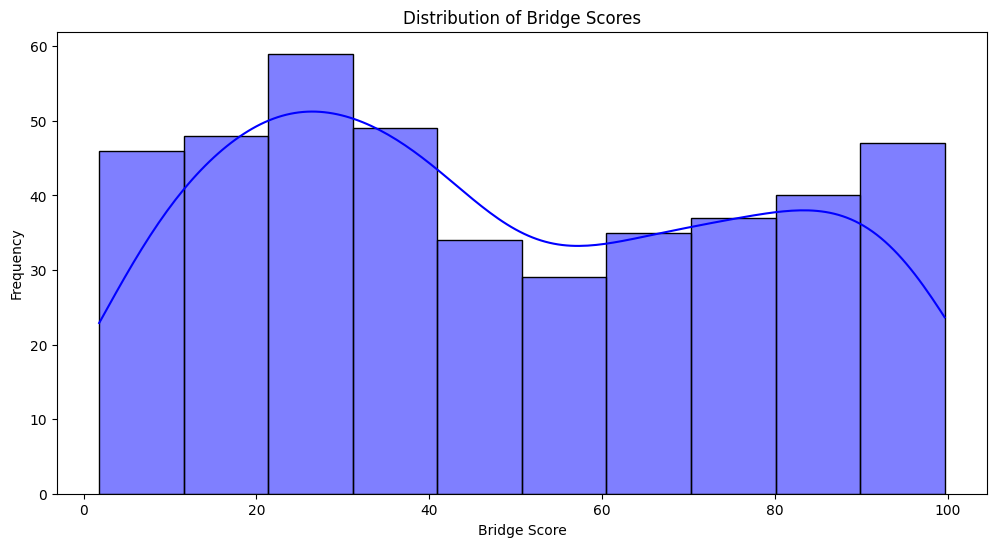

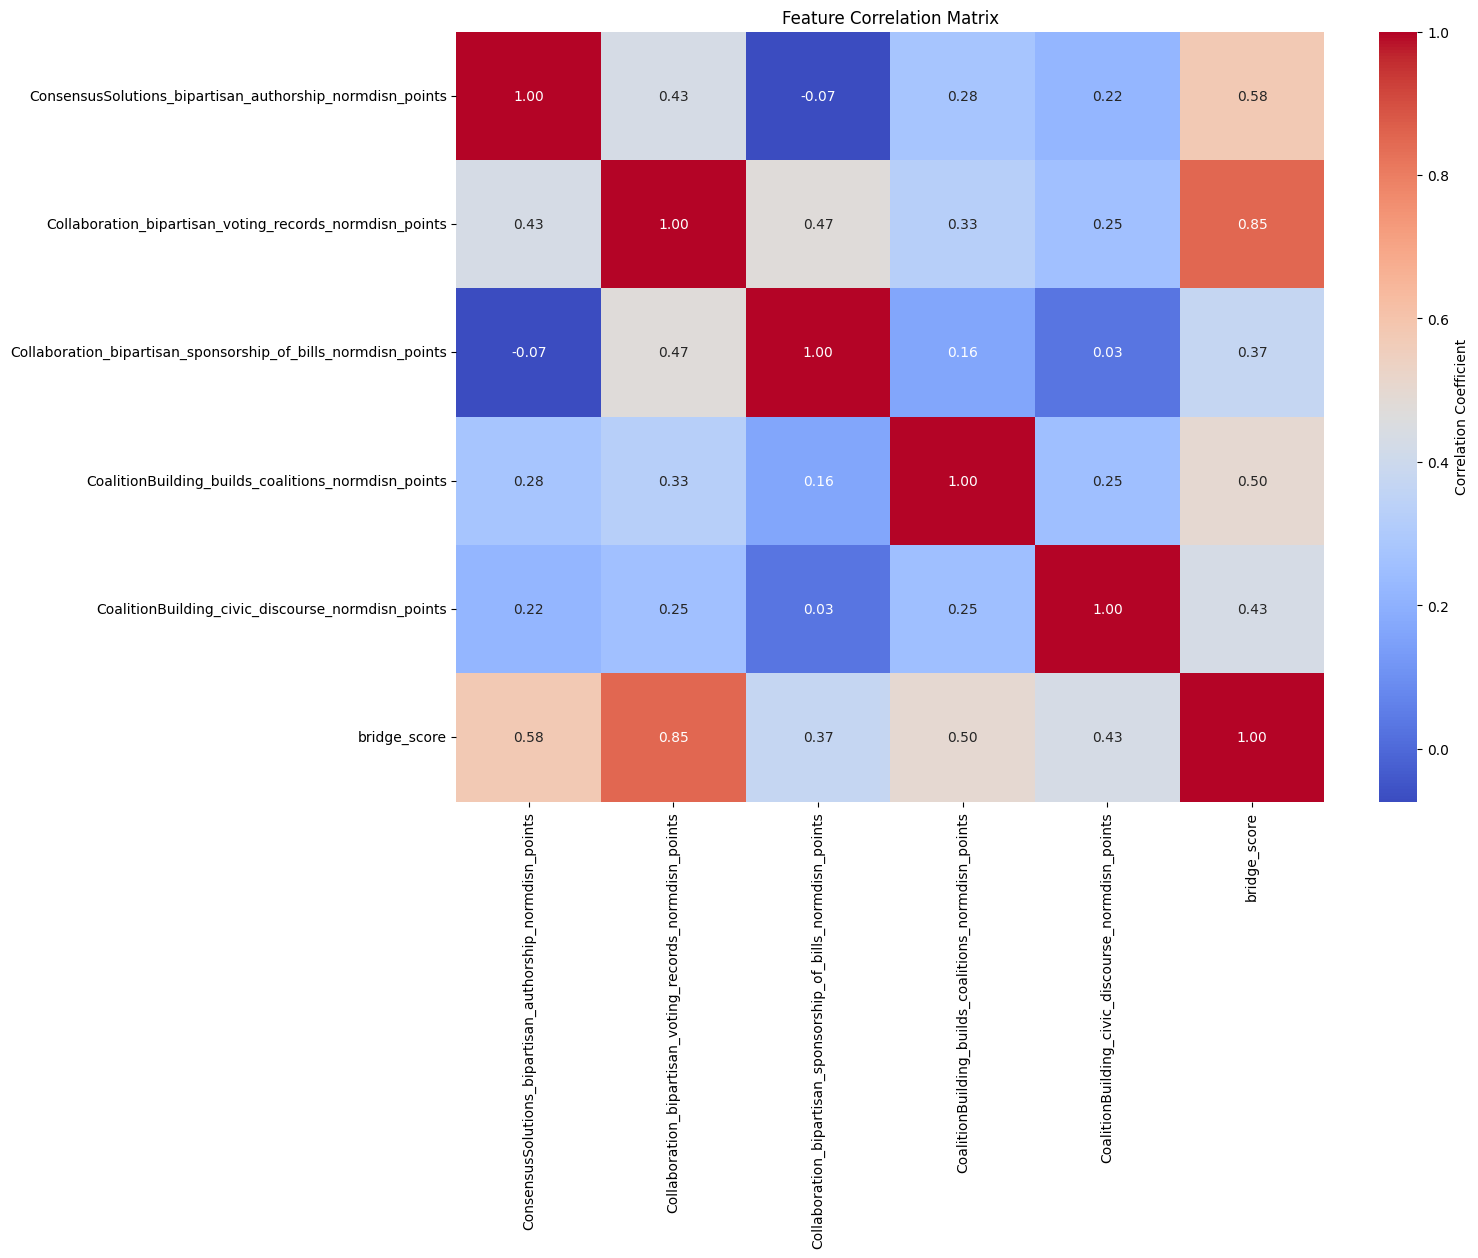

In [7]:
# Something Like this
plt.figure(figsize=(12, 6))
sns.histplot(df['bridge_score'], kde=True, color="blue")
plt.title("Distribution of Bridge Scores")
plt.xlabel("Bridge Score")
plt.ylabel("Frequency")
plt.show()

# Select numeric columns only for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Feature Correlation Matrix")
plt.show()

# Feature Engineering


In [8]:
# Prepare features (X) and target (y) for machine learning
X = df.drop(columns=["bridge_score", "name"])  # Features excluding the target and name
y = df["bridge_score"]  # Target variable
names = df["name"]  # Store names for later analysis

# Impute missing values in features using the median and scale the data for uniformity
imputer = SimpleImputer(strategy='mean')  # Replace missing values with the mean of each column
scaler = StandardScaler()  # Standardize features by removing the mean and scaling to unit variance

X_imputed = imputer.fit_transform(X)  # Fit the imputer and transform the data
X_scaled = scaler.fit_transform(X_imputed)  # Scale the data

# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val, names_train, names_val = train_test_split(X_scaled, y, names, test_size=0.2, random_state=42)


# Model Selection and Hyperparameter Tuning

In [9]:
# Define the parameter grid for hyperparameter tuning with RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 15),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': uniform(0.2, 0.8)
}

# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

# Set up the RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Get the best model after hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Save the best model for later use
model_save_path = '/content/weighted_model.joblib'  # Specify the path where the model will be saved, here I have given path to save in Google Colab
# Save the model and feature names
joblib.dump((best_rf_model, X.columns.tolist()), '/content/weighted_model_with_features.joblib')
print(f"Weighted model saved to {model_save_path}")


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Weighted model saved to /content/weighted_model.joblib


# Model Evaluation

In [10]:
# Make predictions on the training and validation sets
y_train_pred = best_rf_model.predict(X_train)
y_val_pred = best_rf_model.predict(X_val)

# Calculate and print performance metrics for training and validation sets
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)
print(f"Training MSE: {mse_train:.2f}, R²: {r2_train:.2f}")
print(f"Validation MSE: {mse_val:.2f}, R²: {r2_val:.2f}")


Best Parameters from RandomizedSearchCV: {'max_depth': 8, 'max_features': 0.6739316550896339, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 356}
Training MSE: 61.01, R²: 0.93
Validation MSE: 142.53, R²: 0.86


# Error Analysis

In [11]:
# Function to categorize scores into letter grades
def calculate_grade(score):
    if score >= 85:
        return "A"
    elif score >= 70:
        return "B"
    elif score >= 55:
        return "C"
    else:
        return "F"

# Create a DataFrame to hold the validation results and analyze grade changes
results = pd.DataFrame({
    'Name': names_val,
    'Actual': y_val,
    'Predicted': y_val_pred,
    'Error': y_val - y_val_pred
})
results["Actual_Grade"] = results["Actual"].apply(calculate_grade)
results["Predicted_Grade"] = results["Predicted"].apply(calculate_grade)
results["Grade_Changed"] = results["Actual_Grade"] != results["Predicted_Grade"]

# Display members whose predicted grade differs from their actual grade
grade_changes = results[results["Grade_Changed"]]
print("\nMembers with Grade Changes:\n", grade_changes[["Name", "Actual_Grade", "Predicted_Grade", "Error"]])



Members with Grade Changes:
                         Name Actual_Grade Predicted_Grade      Error
145           Claudia Tenney            C               B  -5.671636
132          Carol D. Miller            C               F  32.477182
30           Nikki Budzinski            A               B  19.109246
239           Joaquin Castro            F               C -24.164179
55          David G. Valadao            A               B   9.996821
56                 Jim Costa            A               B   3.796839
272              Wesley Hunt            F               C -26.404953
79           Bruce Westerman            B               C  23.875870
39    Cathy McMorris Rodgers            A               B  13.693836
113           J. Luis Correa            B               C  11.646656
148             Darrell Issa            C               B -11.868064
78        Brittany Pettersen            B               A  -6.553157
82            Sharice Davids            B               F  27.655492
104 

# Visualization

Bridge Score Distribution

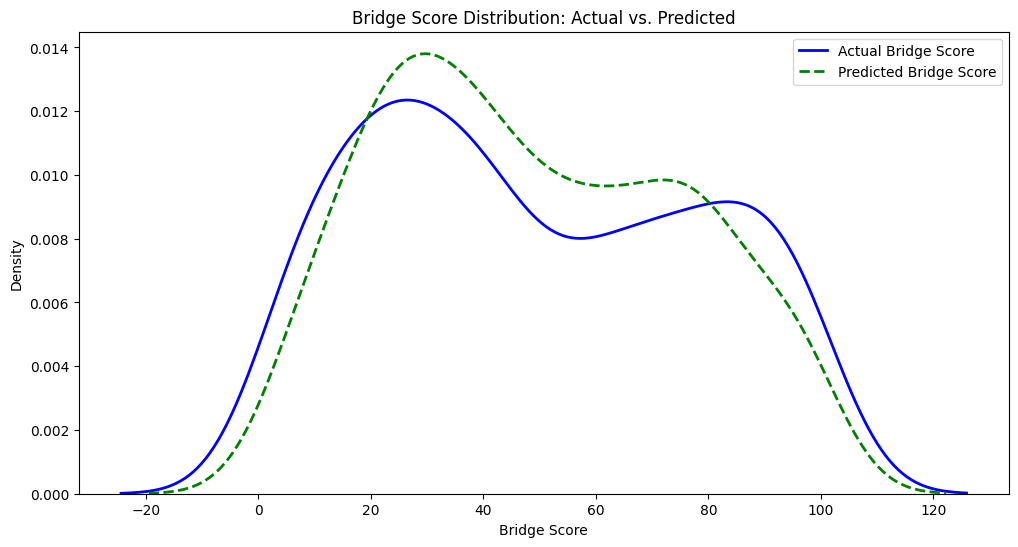

In [12]:
comparison_df = pd.DataFrame({
    "Actual Bridge Score": y,
    "Predicted (Validation)": best_rf_model.predict(X_scaled)
})

plt.figure(figsize=(12, 6))
sns.kdeplot(comparison_df["Actual Bridge Score"], label="Actual Bridge Score", color="blue", linewidth=2)
sns.kdeplot(comparison_df["Predicted (Validation)"], label="Predicted Bridge Score", color="green", linestyle="--", linewidth=2)
plt.title("Bridge Score Distribution: Actual vs. Predicted")
plt.xlabel("Bridge Score")
plt.ylabel("Density")
plt.legend()
plt.show()


Learning Curves

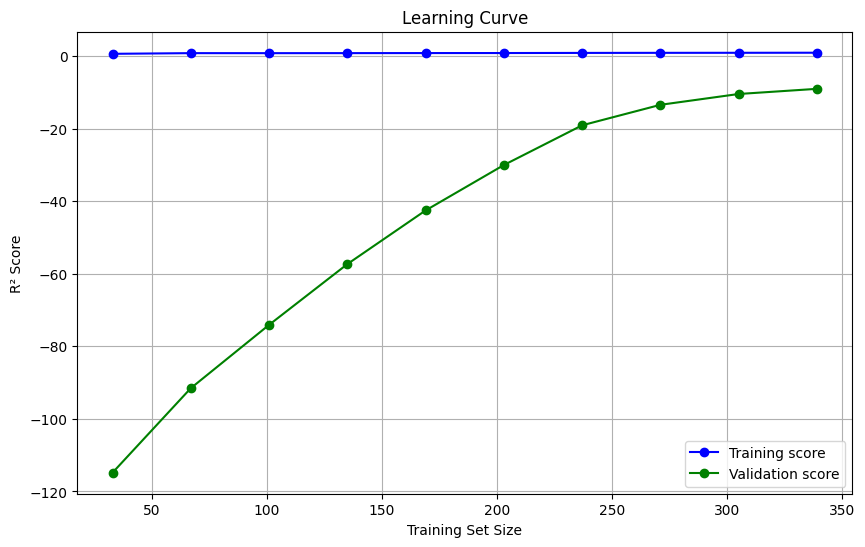

In [13]:
train_sizes, train_scores, val_scores = learning_curve(
    best_rf_model, X_scaled, y, cv=5, scoring='r2', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="green", label="Validation score")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid()
plt.show()



Members with Grade Changes:
                         Name  Actual  Predicted      Error
145           Claudia Tenney   64.98  70.651636  -5.671636
132          Carol D. Miller   68.80  36.322818  32.477182
30           Nikki Budzinski   95.05  75.940754  19.109246
239           Joaquin Castro   38.60  62.764179 -24.164179
55          David G. Valadao   88.16  78.163179   9.996821
56                 Jim Costa   87.56  83.763161   3.796839
272              Wesley Hunt   31.03  57.434953 -26.404953
79           Bruce Westerman   82.69  58.814130  23.875870
39    Cathy McMorris Rodgers   91.53  77.836164  13.693836
113           J. Luis Correa   73.37  61.723344  11.646656
148             Darrell Issa   63.26  75.128064 -11.868064
78        Brittany Pettersen   82.83  89.383157  -6.553157
82            Sharice Davids   82.20  54.544508  27.655492
104            Lloyd Smucker   75.28  65.130082  10.149918
172             Joyce Beatty   57.00  54.076596   2.923404
42           Colin Z. Allr

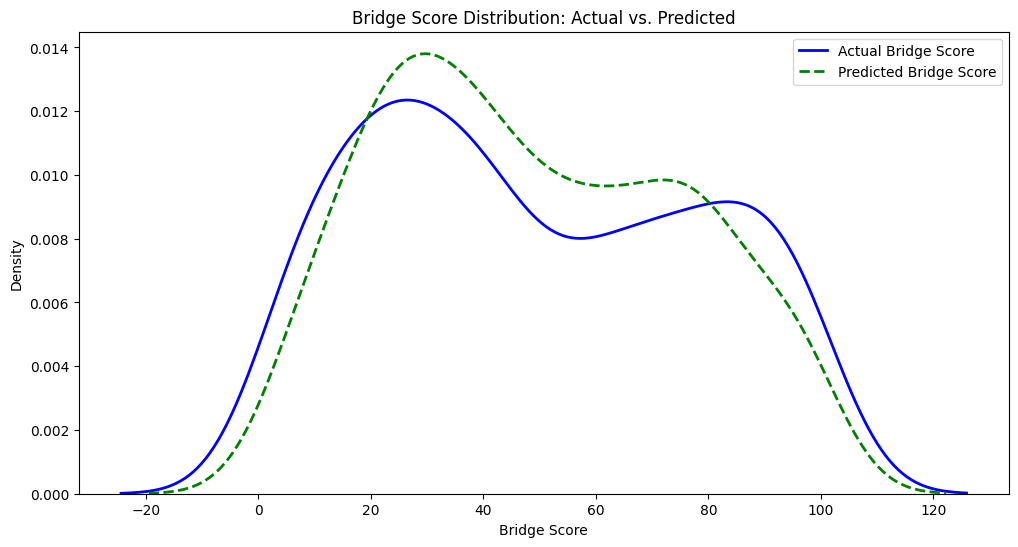

In [14]:
# Error analysis on the validation set
results = pd.DataFrame({
    'Name': names_val,
    'Actual': y_val,
    'Predicted': y_val_pred,
    'Error': y_val - y_val_pred
})
results['Grade_Changed'] = results.apply(lambda row: calculate_grade(row['Actual']) != calculate_grade(row['Predicted']), axis=1)

# Display members with grade changes
grade_changes = results[results['Grade_Changed']]
print("\nMembers with Grade Changes:\n", grade_changes[['Name', 'Actual', 'Predicted', 'Error']])

# Bridge Score Distribution (Actual vs. Predicted)
comparison_df = pd.DataFrame({
    "Actual Bridge Score": y,
    "Predicted (Validation)": best_rf_model.predict(X_scaled)
})

plt.figure(figsize=(12, 6))
sns.kdeplot(comparison_df["Actual Bridge Score"], label="Actual Bridge Score", color="blue", linewidth=2)
sns.kdeplot(comparison_df["Predicted (Validation)"], label="Predicted Bridge Score", color="green", linestyle="--", linewidth=2)
plt.title("Bridge Score Distribution: Actual vs. Predicted")
plt.xlabel("Bridge Score")
plt.ylabel("Density")
plt.legend()
plt.show()


# Custom Weights on 118_house data


Default Weights from Trained Model:
 {'ConsensusSolutions_bipartisan_authorship_normdisn_points': 0.17098038516846067, 'Collaboration_bipartisan_voting_records_normdisn_points': 0.6479684295316435, 'Collaboration_bipartisan_sponsorship_of_bills_normdisn_points': 0.06392024275700861, 'CoalitionBuilding_builds_coalitions_normdisn_points': 0.08244183234764847, 'CoalitionBuilding_civic_discourse_normdisn_points': 0.03468911019523883}

Default Weights - Validation MSE: 485.39, R²: 0.51
Custom Weights - Validation MSE: 163.58, R²: 0.84

Comparison of Predictions:
                    Name  Actual  Predicted (Default Weights)  \
145      Claudia Tenney   64.98                    55.947614   
280       Max L. Miller   29.45                    53.122242   
175   Elise M. Stefanik   56.10                    56.809888   
373   Anna Paulina Luna   13.24                    48.239195   
420          Jim Jordan    2.47                    24.581668   
73     Suzanne Bonamici   84.28                   

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


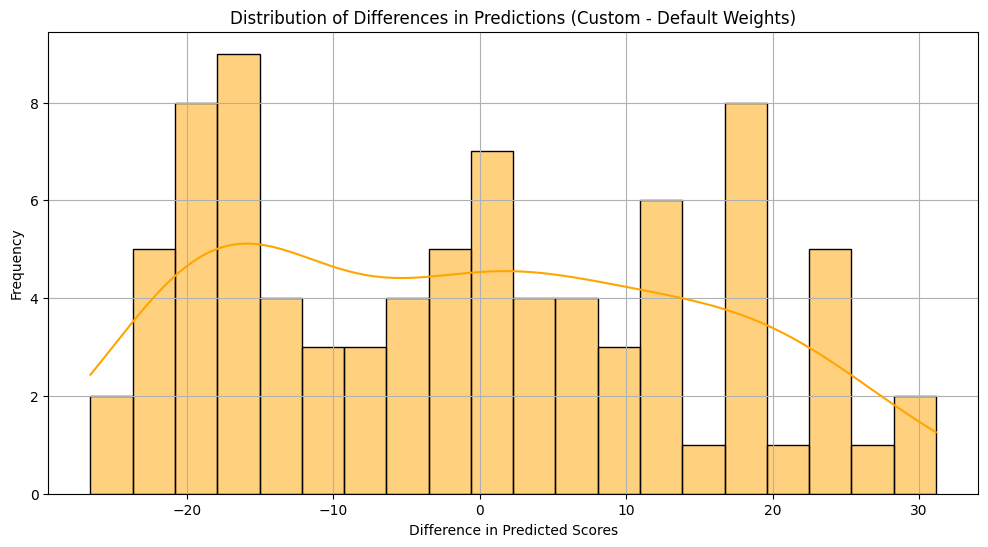

In [30]:
# Load the saved weighted model
weighted_model, feature_names = joblib.load('/content/weighted_model_with_features.joblib')  # Update path

# Set default weights for each metric (from the trained model feature importances)
def get_default_weights(model, feature_names):
    """Get default weights from a trained model's feature importances."""
    feature_importances = model.feature_importances_
    return dict(zip(feature_names, feature_importances))

# Function to apply custom weights to the DataFrame
def apply_custom_weights(df, custom_weights):
    """Apply custom weights to DataFrame."""
    weighted_df = df.copy()
    for metric, weight in custom_weights.items():
        if metric in weighted_df.columns:
            weighted_df[metric] *= weight
    return weighted_df

# Get default weights from the saved model
default_weights = get_default_weights(weighted_model, feature_names)
print("\nDefault Weights from Trained Model:\n", default_weights)

# Define custom weights for testing
custom_weights = {
    "ConsensusSolutions_bipartisan_authorship_normdisn_points": 1.2,
    "Collaboration_bipartisan_voting_records_normdisn_points": 0.8,
    "CoalitionBuilding_builds_coalitions_normdisn_points": 1.1,
    "CoalitionBuilding_civic_discourse_normdisn_points": 1.0
    # add more metrics if available/needed
}

# Apply default weights and predict (on validation set)
X_val_default_weighted = apply_custom_weights(pd.DataFrame(X_val, columns=feature_names), default_weights)
y_val_pred_default = weighted_model.predict(X_val_default_weighted)

# Apply custom weights and predict (on validation set)
X_val_custom_weighted = apply_custom_weights(pd.DataFrame(X_val, columns=feature_names), custom_weights)
y_val_pred_custom = weighted_model.predict(X_val_custom_weighted)

# Calculate and print metrics for both scenarios
mse_default = mean_squared_error(y_val, y_val_pred_default)
r2_default = r2_score(y_val, y_val_pred_default)

mse_custom = mean_squared_error(y_val, y_val_pred_custom)
r2_custom = r2_score(y_val, y_val_pred_custom)

print(f"\nDefault Weights - Validation MSE: {mse_default:.2f}, R²: {r2_default:.2f}")
print(f"Custom Weights - Validation MSE: {mse_custom:.2f}, R²: {r2_custom:.2f}")

# Compare predictions
comparison = pd.DataFrame({
    "Name": names_val,
    "Actual": y_val,
    "Predicted (Default Weights)": y_val_pred_default,
    "Predicted (Custom Weights)": y_val_pred_custom,
    "Difference": y_val_pred_custom - y_val_pred_default
})

print("\nComparison of Predictions:\n", comparison.head(10))

# Visualize differences
plt.figure(figsize=(12, 6))
sns.histplot(comparison["Difference"], kde=True, color="orange", bins=20)
plt.title("Distribution of Differences in Predictions (Custom - Default Weights)")
plt.xlabel("Difference in Predicted Scores")
plt.ylabel("Frequency")
plt.grid()
plt.show()


# Scoring for New Data using Default or Custom Weights
In the codes below, type load when asked- "Would you like to load custom weights or enter new weights?" to use weights trained on 118-119house_data.



To use custom weights on new data, type enter when asked- "Would you like to load custom weights or enter new weights?" and then add weights for each metrics



Default Weights from Trained Model:
 {'ConsensusSolutions_bipartisan_authorship_normdisn_points': 0.17098038516846067, 'Collaboration_bipartisan_voting_records_normdisn_points': 0.6479684295316435, 'Collaboration_bipartisan_sponsorship_of_bills_normdisn_points': 0.06392024275700861, 'CoalitionBuilding_builds_coalitions_normdisn_points': 0.08244183234764847, 'CoalitionBuilding_civic_discourse_normdisn_points': 0.03468911019523883}

Would you like to load custom weights or enter new weights? [load/enter]
enter

Enter custom weights for the following metrics (press Enter to skip):
Weight for ConsensusSolutions_bipartisan_authorship_normdisn_points: 2
Weight for Collaboration_bipartisan_voting_records_normdisn_points: 2
Weight for Collaboration_bipartisan_sponsorship_of_bills_normdisn_points: 2
Weight for CoalitionBuilding_builds_coalitions_normdisn_points: 
Weight for CoalitionBuilding_civic_discourse_normdisn_points: 2

Do you want to save these custom weights for future use? [yes/no]: 

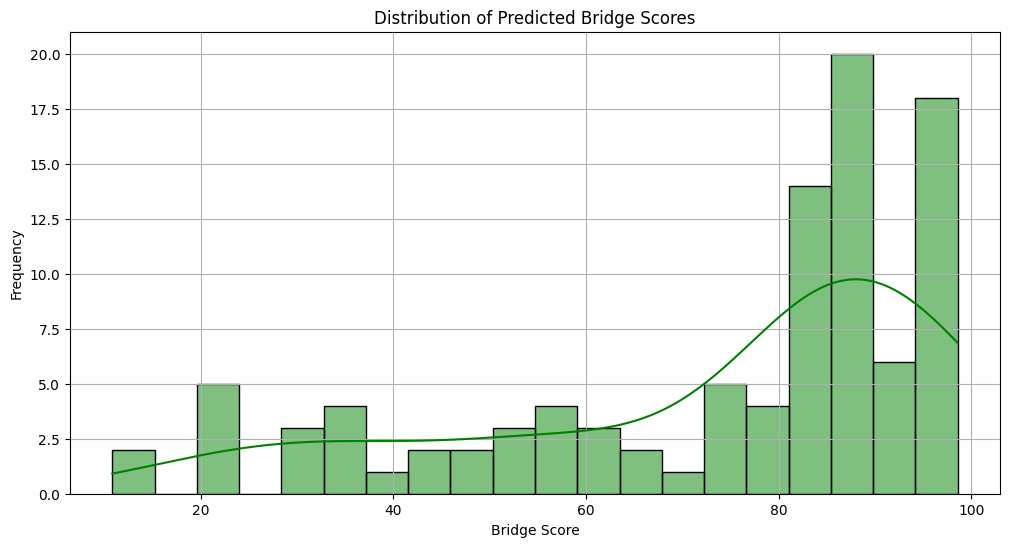

In [18]:
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Utility Functions
def get_default_weights(model, feature_names):
    """Get default weights from a trained model's feature importances."""
    feature_importances = model.feature_importances_
    return dict(zip(feature_names, feature_importances))

def apply_custom_weights(df, custom_weights):
    """Apply custom weights to DataFrame."""
    weighted_df = df.copy()
    for metric, weight in custom_weights.items():
        if metric in weighted_df.columns:
            weighted_df[metric] *= weight
    return weighted_df

def score_new_data(new_data, model, feature_names, imputer, scaler, custom_weights=None):
    """Score new data using the specified model, features, and weights."""
    # Convert new JSON data to a DataFrame
    new_df = json_to_dataframe(new_data)

    # Save the identifiers (name or bioid) for results
    identifiers = new_df.get("name", new_df.get("bioid", ["N/A"] * len(new_data)))

    # Align features with the training data
    feature_df = new_df[feature_names].copy()  # Only keep columns matching feature names
    for feature in feature_names:
        if feature not in feature_df.columns:
            feature_df[feature] = 0  # Add missing features with default value

    # Apply custom weights if provided
    if custom_weights:
        feature_df = apply_custom_weights(feature_df, custom_weights)

    # Impute and scale
    feature_df_imputed = imputer.transform(feature_df)
    feature_df_scaled = scaler.transform(feature_df_imputed)

    # Predict bridge scores
    new_scores = model.predict(feature_df_scaled)

    # Calculate grades for each new bridge score
    new_grades = [calculate_grade(score) for score in new_scores]

    # Create results DataFrame
    results = pd.DataFrame({
        "Identifier": identifiers,  # Use saved identifiers like bioid or name
        "Predicted Bridge Score": new_scores,
        "Predicted Grade": new_grades
    })
    return results


def save_custom_weights(custom_weights, filename="custom_weights.json"):
    """Save custom weights to a file."""
    with open(filename, 'w') as f:
        json.dump(custom_weights, f)
    print(f"Custom weights saved to {filename}.")

def load_custom_weights(filename="custom_weights.json"):
    """Load custom weights from a JSON file."""
    try:
        with open(filename, 'r') as f:
            custom_weights = json.load(f)
        print(f"Custom weights loaded from {filename}.") # Custom weights are any weights which user has created in JSON format
        return custom_weights
    except FileNotFoundError:
        print(f"File {filename} not found. Using default weights.") # If custom weights not specified, use default weights
        return None
    except json.JSONDecodeError:
        print(f"Error decoding JSON from {filename}. Ensure the file is a valid JSON file.")
        return None

# Load the saved model and feature names
weighted_model, feature_names = joblib.load('/content/weighted_model_with_features.joblib')  # Update path

# Get default weights based on the loaded feature names
default_weights = get_default_weights(weighted_model, feature_names)

# Print default weights for transparency
print("\nDefault Weights from Trained Model:\n", default_weights)

# Prompt user for custom weights or loading previously saved ones
print("\nWould you like to load custom weights or enter new weights? [load/enter]")
choice = input().strip().lower()

# Handle user's choice
if choice == "load":
    custom_weights = load_custom_weights()
elif choice == "enter":
    custom_weights = {}
    print("\nEnter custom weights for the following metrics (press Enter to skip):")
    for feature in feature_names:
        try:
            weight = input(f"Weight for {feature}: ").strip()
            if weight:
                custom_weights[feature] = float(weight)
        except ValueError:
            print(f"Invalid weight entered for {feature}. Skipping...")
else:
    print("\nInvalid choice. Using default weights.")
    custom_weights = default_weights

# Save custom weights if entered
if choice == "enter" and custom_weights:
    save_choice = input("\nDo you want to save these custom weights for future use? [yes/no]: ").strip().lower()
    if save_choice == "yes":
        save_custom_weights(custom_weights)


# 4. Load new data for scoring
print("\nWould you like to load a JSON file for new data? [yes/no]")
load_new_data_choice = input().strip().lower()

if load_new_data_choice == "yes":
    json_path = input("Enter path to the JSON file: ").strip()
    try:
        with open(json_path, 'r') as f:
            new_data = json.load(f)
    except FileNotFoundError:
        print(f"File {json_path} not found. Exiting...")
        new_data = None
else:
    print("\nNo new data loaded. Exiting...")
    new_data = None

# 5. Score new data if provided
if new_data:
    try:
        new_results = score_new_data(new_data, weighted_model, feature_names, imputer, scaler, custom_weights)
        print("\nScoring Results for New Data:\n", new_results.head(50))

        # Visualize predicted scores
        plt.figure(figsize=(12, 6))
        sns.histplot(new_results["Predicted Bridge Score"], kde=True, color="green", bins=20)
        plt.title("Distribution of Predicted Bridge Scores")
        plt.xlabel("Bridge Score")
        plt.ylabel("Frequency")
        plt.grid()
        plt.show()

    except Exception as e:
        print(f"Error scoring new data: {e}")



If want to add new metric, type in the name and its weight(make sure it is present in the data)

Still in work

In [32]:
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Utility Functions
def get_default_weights(model, feature_names):
    """Get default weights from a trained model's feature importances."""
    feature_importances = model.feature_importances_
    return dict(zip(feature_names, feature_importances))

def apply_custom_weights(df, custom_weights):
    """Apply custom weights to DataFrame."""
    weighted_df = df.copy()
    for metric, weight in custom_weights.items():
        if metric in weighted_df.columns:
            weighted_df[metric] *= weight
        else:
            print(f"Adding new metric '{metric}' with default values.")
            weighted_df[metric] = 0  # Add new metric with default value
            weighted_df[metric] *= weight
    return weighted_df

def score_new_data(new_data, model, feature_names, imputer, scaler, custom_weights=None):
    """Score new data using the specified model, features, and weights."""
    # Convert new JSON data to a DataFrame
    new_df = json_to_dataframe(new_data)

    # Save the identifiers (name or bioid) for results
    identifiers = new_df.get("name", new_df.get("bioid", ["N/A"] * len(new_data)))

    # Align features with the training data
    feature_df = new_df[feature_names].copy()
    for feature in feature_names:
        if feature not in feature_df.columns:
            feature_df[feature] = 0  # Add missing features with default value

    # Apply custom weights if provided
    if custom_weights:
        feature_df = apply_custom_weights(feature_df, custom_weights)

    # Impute and scale
    feature_df_imputed = imputer.transform(feature_df)
    feature_df_scaled = scaler.transform(feature_df_imputed)

    # Predict bridge scores
    new_scores = model.predict(feature_df_scaled)

    # Calculate grades for each new bridge score
    new_grades = [calculate_grade(score) for score in new_scores]

    # Create results DataFrame
    results = pd.DataFrame({
        "Identifier": identifiers,  # Use saved identifiers
        "Predicted Bridge Score": new_scores,
        "Predicted Grade": new_grades
    })
    return results

def save_custom_weights(custom_weights, filename="custom_weights.json"):
    """Save custom weights to a file."""
    with open(filename, 'w') as f:
        json.dump(custom_weights, f)
    print(f"Custom weights saved to {filename}.")

def load_custom_weights(filename="custom_weights.json"):
    """Load custom weights from a file."""
    try:
        with open(filename, 'r') as f:
            custom_weights = json.load(f)
        print(f"Custom weights loaded from {filename}.")
        return custom_weights
    except FileNotFoundError:
        print(f"File {filename} not found. Using default weights.")
        return None
    except json.JSONDecodeError:
        print(f"Error decoding JSON from {filename}. Ensure the file is valid.")
        return None

# Main Execution

# 1. Load the saved model
weighted_model, feature_names = joblib.load('/content/weighted_model_with_features.joblib')  # Update path

# Get default weights based on the loaded feature names
default_weights = get_default_weights(weighted_model, feature_names)

# Print default weights
print("\nDefault Weights from Trained Model:\n", default_weights)

# 2. Add new metrics and weights
print("\nDo you want to add a new metric? [yes/no]")
add_metric_choice = input().strip().lower()

if add_metric_choice == "yes":
    print("\nEnter the new metrics and their weights:")
    while True:
        new_metric = input("Enter the new metric name (or 'done' to finish): ").strip()
        if new_metric.lower() == "done":
            break
        try:
            weight = float(input(f"Enter weight for {new_metric}: ").strip())
            default_weights[new_metric] = weight
            print(f"Added metric '{new_metric}' with weight {weight}.")
        except ValueError:
            print("Invalid weight. Please try again.")

# Save custom weights if entered
save_choice = input("\nDo you want to save these weights for future use? [yes/no]: ").strip().lower()
if save_choice == "yes":
    save_custom_weights(default_weights)

# 3. Load new data for scoring
print("\nWould you like to load a JSON file for new data? [yes/no]")
load_new_data_choice = input().strip().lower()

if load_new_data_choice == "yes":
    json_path = input("Enter path to the JSON file: ").strip()
    try:
        with open(json_path, 'r') as f:
            new_data = json.load(f)
    except FileNotFoundError:
        print(f"File {json_path} not found. Exiting...")
        new_data = None
else:
    print("\nNo new data loaded. Exiting...")
    new_data = None

# 4. Score new data if provided
if new_data:
    try:
        new_results = score_new_data(new_data, weighted_model, feature_names, imputer, scaler, default_weights)
        print("\nScoring Results for New Data:\n", new_results.head(50))

        # Visualize predicted scores
        plt.figure(figsize=(12, 6))
        sns.histplot(new_results["Predicted Bridge Score"], kde=True, color="green", bins=20)
        plt.title("Distribution of Predicted Bridge Scores")
        plt.xlabel("Bridge Score")
        plt.ylabel("Frequency")
        plt.grid()
        plt.show()
    except Exception as e:
        print(f"Error scoring new data: {e}")



Default Weights from Trained Model:
 {'ConsensusSolutions_bipartisan_authorship_normdisn_points': 0.17098038516846067, 'Collaboration_bipartisan_voting_records_normdisn_points': 0.6479684295316435, 'Collaboration_bipartisan_sponsorship_of_bills_normdisn_points': 0.06392024275700861, 'CoalitionBuilding_builds_coalitions_normdisn_points': 0.08244183234764847, 'CoalitionBuilding_civic_discourse_normdisn_points': 0.03468911019523883}

Do you want to add a new metric? [yes/no]
yes

Enter the new metrics and their weights:
Enter the new metric name (or 'done' to finish): democracy
Enter weight for democracy: 2
Added metric 'democracy' with weight 2.0.
Enter the new metric name (or 'done' to finish): done

Do you want to save these weights for future use? [yes/no]: no

Would you like to load a JSON file for new data? [yes/no]
yes
Enter path to the JSON file: /content/data.json
Adding new metric 'democracy' with default values.
Error scoring new data: The feature names should match those that

# Combined Code, Please ignore

Best Parameters from RandomizedSearchCV: {'max_depth': 8, 'max_features': 0.6739316550896339, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 356}
Training MSE: 61.01, R²: 0.93
Validation MSE: 142.53, R²: 0.86

Members with Grade Changes:
                         Name Actual_Grade Predicted_Grade      Error
145           Claudia Tenney            C               B  -5.671636
132          Carol D. Miller            C               F  32.477182
30           Nikki Budzinski            A               B  19.109246
239           Joaquin Castro            F               C -24.164179
55          David G. Valadao            A               B   9.996821
56                 Jim Costa            A               B   3.796839
272              Wesley Hunt            F               C -26.404953
79           Bruce Westerman            B               C  23.875870
39    Cathy McMorris Rodgers            A               B  13.693836
113           J. Luis Correa            B              

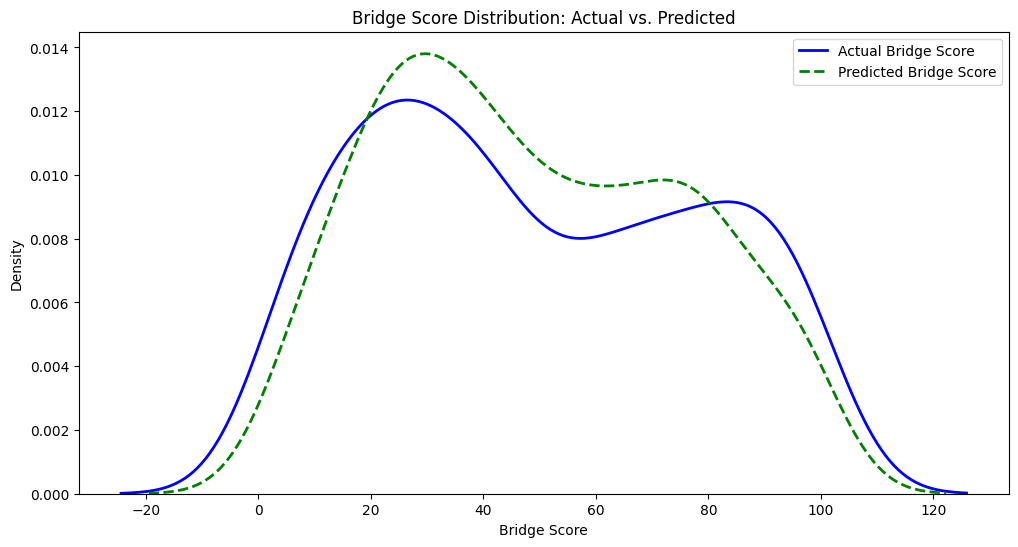

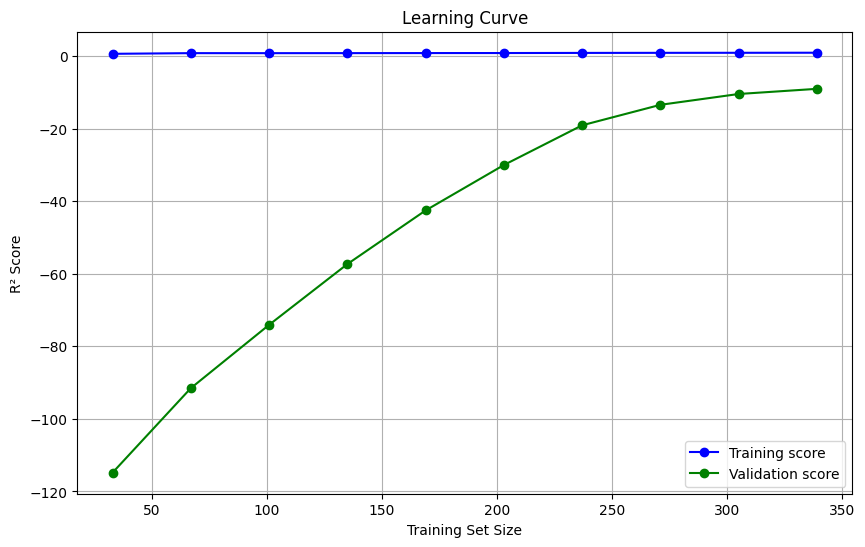

In [ ]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import matplotlib.pyplot as plt  # For plotting charts
import seaborn as sns  # For creating visually appealing statistical plots
import pandas as pd  # For working with data in a tabular format
import json  # For reading and working with JSON data
from sklearn.ensemble import RandomForestRegressor  # Machine learning model for regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve  # For model evaluation and training
from sklearn.metrics import mean_squared_error, r2_score  # For evaluating model performance
from sklearn.impute import SimpleImputer  # For handling missing data
from sklearn.preprocessing import StandardScaler  # For scaling data to a standard range
from scipy.stats import randint, uniform  # For defining parameter distributions in hyperparameter tuning
import numpy as np  # For numerical operations

# Load JSON data from a file and parse it into a Python object
with open('/content/118-119house_data.json', 'r') as f:
    data = json.load(f)  # Load the JSON data from the file

# Function to convert JSON data to a Pandas DataFrame
# This function extracts only relevant information and excludes specific data (e.g., common ground scores)
def json_to_dataframe(data):
    records = []  # List to hold individual member records
    for member in data:
        year_data = member["year"].get("118_house", {})  # Extract year-specific data
        record = {"name": member["name"]}  # Include the member's name

        # Extract only selected metrics, excluding 'common_ground_performance'
        for section, metrics in year_data.items():
            if section in ["ConsensusSolutions", "Collaboration", "CoalitionBuilding"]:
                for metric, scores in metrics.items():
                    if metric != "common_ground_performance":  # Exclude this metric
                        record[f"{section}_{metric}_normdisn_points"] = scores.get("normdisn_points", None)  # Get normalized scores

        # Add the target variable (bridge_score)
        record["bridge_score"] = year_data.get("bridge_score")
        records.append(record)  # Append the record to the list
    return pd.DataFrame(records)  # Convert the list to a DataFrame

# Convert the JSON data to a DataFrame and remove any rows where the target variable is missing
df = json_to_dataframe(data).dropna(subset=["bridge_score"])

# Prepare features (X) and target (y) for machine learning
X = df.drop(columns=["bridge_score", "name"])  # Features excluding the target and name
y = df["bridge_score"]  # Target variable
names = df["name"]  # Store names for later analysis

# Impute missing values in features using the median and scale the data for uniformity
imputer = SimpleImputer(strategy='median')  # Replace missing values with the median of each column
scaler = StandardScaler()  # Standardize features by removing the mean and scaling to unit variance

X_imputed = imputer.fit_transform(X)  # Fit the imputer and transform the data
X_scaled = scaler.fit_transform(X_imputed)  # Scale the data

# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val, names_train, names_val = train_test_split(X_scaled, y, names, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning with RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 500),  # Number of trees in the forest
    'max_depth': randint(5, 15),  # Maximum depth of the tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 10),  # Minimum number of samples required to be at a leaf node
    'max_features': uniform(0.2, 0.8)  # Number of features to consider when looking for the best split
}

# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

# Set up the RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(
    rf_model,  # Model to tune
    param_distributions=param_distributions,  # Parameter grid to sample from
    n_iter=20,  # Number of parameter settings to try
    scoring='r2',  # Metric to optimize
    cv=5,  # Number of cross-validation folds
    random_state=42,  # Random state for reproducibility
    n_jobs=-1  # Use all available cores for parallel processing
)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Get the best model after hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Make predictions on the training and validation sets
y_train_pred = best_rf_model.predict(X_train)
y_val_pred = best_rf_model.predict(X_val)

# Calculate and print performance metrics for training and validation sets
mse_train = mean_squared_error(y_train, y_train_pred)  # Mean squared error for training set
r2_train = r2_score(y_train, y_train_pred)  # R-squared score for training set
mse_val = mean_squared_error(y_val, y_val_pred)  # Mean squared error for validation set
r2_val = r2_score(y_val, y_val_pred)  # R-squared score for validation set

print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)
print(f"Training MSE: {mse_train:.2f}, R²: {r2_train:.2f}")
print(f"Validation MSE: {mse_val:.2f}, R²: {r2_val:.2f}")

# Function to categorize scores into letter grades
def calculate_grade(score):
    if score >= 85:
        return "A"
    elif score >= 70:
        return "B"
    elif score >= 55:
        return "C"
    else:
        return "F"

# Create a DataFrame to hold the validation results and analyze grade changes
results = pd.DataFrame({
    'Name': names_val,  # Name of the member
    'Actual': y_val,  # Actual bridge score
    'Predicted': y_val_pred,  # Predicted bridge score
    'Error': y_val - y_val_pred  # Difference between actual and predicted
})
results["Actual_Grade"] = results["Actual"].apply(calculate_grade)  # Apply grading function to actual scores
results["Predicted_Grade"] = results["Predicted"].apply(calculate_grade)  # Apply grading function to predicted scores
results["Grade_Changed"] = results["Actual_Grade"] != results["Predicted_Grade"]  # Check if the grade changed

# Display members whose predicted grade differs from their actual grade
grade_changes = results[results["Grade_Changed"]]
print("\nMembers with Grade Changes:\n", grade_changes[["Name", "Actual_Grade", "Predicted_Grade", "Error"]])

# Plot the distribution of actual and predicted bridge scores for visual comparison
comparison_df = pd.DataFrame({
    "Actual Bridge Score": y,
    "Predicted (Validation)": best_rf_model.predict(X_scaled)
})

plt.figure(figsize=(12, 6))
sns.kdeplot(comparison_df["Actual Bridge Score"], label="Actual Bridge Score", color="blue", linewidth=2)
sns.kdeplot(comparison_df["Predicted (Validation)"], label="Predicted Bridge Score", color="green", linestyle="--", linewidth=2)
plt.title("Bridge Score Distribution: Actual vs. Predicted")
plt.xlabel("Bridge Score")
plt.ylabel("Density")
plt.legend()
plt.show()

# Plot learning curves to visualize the model's learning performance
train_sizes, train_scores, val_scores = learning_curve(
    best_rf_model, X_scaled, y, cv=5, scoring='r2', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate the mean scores for plotting
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="green", label="Validation score")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid()
plt.show()
